In this notebook we'll use the example of graphite to demonstrate how to run castep calculations with various dispersion corrections. 


In [3]:
# ASE version 3.23.0
from ase.io import read, write
from ase.calculators.castep import Castep
from ase.io.castep import read_seed
from ase.visualize import view

# pandas version 1.3.4
import pandas as pd

# castep.mpi on path already, version 24.1
castep_cmd = 'mpirun -n 16 castep.mpi'

# plotting default settings
from matplotlib import pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
%matplotlib inline



In [2]:
!castep.serial --version

 CASTEP version: 24.1  

 Compiled for linux_x86_64_gfortran on Mon, 09 Sep 2024 10:41:23 +0000
 from code version git version unavailable
 Compiler: GNU Fortran 9.4.0; Optimisation: fast
 Comms   : serial
 MATHLIBS: default (LAPACK version 3.9.0)
 FFT Lib : default
 Fundamental constants values: CODATA 2018


In [4]:
def extract_dispersion_corrected_energy(file_path):
    """
    Extracts the dispersion corrected final energy from a .castep file.

    Parameters:
    file_path (str): Path to the .castep file.

    Returns:
    float: The extracted energy value in eV.
    """
    energy = None
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Iterate over the lines in reverse order to find the last occurrence
    for line in reversed(lines):
        if "Dispersion corrected final energy" in line:
            energy = float(line.split()[-2])
            break
    
    if energy is None:
        raise ValueError("Energy not found in the file.")
    
    return energy

## Separation of layers


In [15]:
# run in this directorsy
directory = 'separate-layers-tutorial/'

# k-point grid -- not converged! 
kpts  = [13,13,5]
# xc functional to use
xc = 'PBE' 
# range of unit c parameters in Angstroms (interlayer spacings are half these!)
crange = [4, 5, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 8.5, 10, 14, 16]

#SEDC correction schemes to try:
schemes = ['', 'G06', 'D3', 'D3-BJ', 'D4', 'TS', 'MBD', 'XDM']

# pandas dataframe to store the results
df = pd.DataFrame({'crange' : crange})

# loop over the different correction schemes
for sedc_scheme in schemes:
    print('\n',50*'=')
    print(f'{xc} + {sedc_scheme}\n')
    
    # list to temporarily hold the total energy for each calculation
    energies = []

    # loop over c parameters:
    for c in crange:
        label = f'{xc}-{sedc_scheme}-{c:3.2f}'
        try:
            graphite = read_seed(directory+label)
            
        except:
            # if the calculation doesn't already exist, we set it up and 
            # run it

            # read in cif file (taken from here: https://materialsproject.org/materials/mp-48 )
            graphite = read('C_mp-48_primitive.cif')

            # For CASTEP < 24.1 we might need a supercell to get more accurate results 
            # for TS, MBD and XDM schemes that rely on Hirshfeld charges.  
            # graphite = graphite * (3,3,1)

            # scale c parameter to new value
            cellpar = graphite.cell.cellpar()
            cellpar[2] = c
            graphite.set_cell(cellpar, scale_atoms=True)
            
            # set up castep calculator
            calc = Castep(
                        kpts = kpts, 
                        label = label, 
                        castep_command = castep_cmd, 
                        directory = directory,
                        _rename_existing_dir = False, # allows us to write all these calculations to the same directory... 
                        )
            
            calc.param.xc_functional = xc
            calc.param.basis_precision = 'precise' # switch to something cheaper (e.g. FINE) to speed things up for this example..
            calc.param.write_checkpoint = 'None' # don't need the checkpoint files now
            calc.param.write_cst_esp = False # don't need the electrostatic potential file now
            calc.param.write_bands   = False # don't need the bands file now

            calc.cell.symmetry_generate = True # use symmetry to speed up the calculation
            calc.cell.snap_to_symmetry = True  # enforce symmetry
            
            # Switch on the SEDC flags 
            if sedc_scheme != '':
                calc.param.sedc_apply = True
                calc.param.sedc_scheme = sedc_scheme
            
            # For the XDM scheme we need to set this manually
            # otherwise the calculation crashes... 
            if sedc_scheme == 'XDM':
                calc.param.SEDC_SC_XDM = 1.0
                
            graphite.set_calculator(calc)
        e = graphite.get_potential_energy()
        # If a SEDC scheme is used, 
        # we need to extract the dispersion corrected energy
        if sedc_scheme != '':
            e = extract_dispersion_corrected_energy(directory+label+'.castep')
        energies.append(e)
        print(f'{c:8.3f} A\t {e:12.8f} eV')
    # save the energy wrt to furthest energy: 
    energies =  [e - energies[-1] for e in energies]
    df[f'{xc}-{sedc_scheme}']  =energies


# Save to a .csv file: 
df.to_csv('graphite_layer_separation.csv')


PBE + 



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -626.08939794 eV
   5.000 A	 -629.78727395 eV
   6.000 A	 -630.70306992 eV
   6.250 A	 -630.78050069 eV
   6.500 A	 -630.83188256 eV
   6.750 A	 -630.86625048 eV
   7.000 A	 -630.88799249 eV
   7.250 A	 -630.90282380 eV
   7.500 A	 -630.91080394 eV
   8.500 A	 -630.92063415 eV
  10.000 A	 -630.91646306 eV
  14.000 A	 -630.90901750 eV
  16.000 A	 -630.90921935 eV

PBE + G06



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -626.93591405 eV
   5.000 A	 -630.55174754 eV
   6.000 A	 -631.32862816 eV
   6.250 A	 -631.35506629 eV
   6.500 A	 -631.35904254 eV
   6.750 A	 -631.35168527 eV
   7.000 A	 -631.33770442 eV
   7.250 A	 -631.32225792 eV
   7.500 A	 -631.30460839 eV
   8.500 A	 -631.24466861 eV
  10.000 A	 -631.18910870 eV
  14.000 A	 -631.14014430 eV
  16.000 A	 -631.13429979 eV

PBE + D3



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -626.55614475 eV
   5.000 A	 -630.25512412 eV
   6.000 A	 -631.13763009 eV
   6.250 A	 -631.19852058 eV
   6.500 A	 -631.23121607 eV
   6.750 A	 -631.24624244 eV
   7.000 A	 -631.24905966 eV
   7.250 A	 -631.24583824 eV
   7.500 A	 -631.23667538 eV
   8.500 A	 -631.18566788 eV
  10.000 A	 -631.12097112 eV
  14.000 A	 -631.06257909 eV
  16.000 A	 -631.05575029 eV

PBE + D3-BJ



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -626.90956509 eV
   5.000 A	 -630.60414428 eV
   6.000 A	 -631.41243893 eV
   6.250 A	 -631.45910580 eV
   6.500 A	 -631.48063221 eV
   6.750 A	 -631.48662479 eV
   7.000 A	 -631.48184498 eV
   7.250 A	 -631.47218928 eV
   7.500 A	 -631.45780782 eV
   8.500 A	 -631.39841629 eV
  10.000 A	 -631.33595347 eV
  14.000 A	 -631.27936944 eV
  16.000 A	 -631.27259525 eV

PBE + D4



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -627.10592472 eV
   5.000 A	 -630.73161034 eV
   6.000 A	 -631.49718536 eV
   6.250 A	 -631.54010333 eV
   6.500 A	 -631.55820254 eV
   6.750 A	 -631.56100647 eV
   7.000 A	 -631.55327693 eV
   7.250 A	 -631.54092168 eV
   7.500 A	 -631.52413843 eV
   8.500 A	 -631.45799998 eV
  10.000 A	 -631.39268094 eV
  14.000 A	 -631.34275794 eV
  16.000 A	 -631.33969415 eV

PBE + TS



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -626.99671069 eV
   5.000 A	 -630.51158768 eV
   6.000 A	 -631.33491453 eV
   6.250 A	 -631.39737671 eV
   6.500 A	 -631.42684643 eV
   6.750 A	 -631.43058106 eV
   7.000 A	 -631.41587034 eV
   7.250 A	 -631.39263067 eV
   7.500 A	 -631.36423164 eV
   8.500 A	 -631.26592916 eV
  10.000 A	 -631.18173223 eV
  14.000 A	 -631.11144613 eV
  16.000 A	 -631.10308743 eV

PBE + MBD



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -627.03023018 eV
   5.000 A	 -630.56959062 eV
   6.000 A	 -631.36678789 eV
   6.250 A	 -631.41655820 eV
   6.500 A	 -631.44095212 eV
   6.750 A	 -631.44924390 eV
   7.000 A	 -631.44620102 eV
   7.250 A	 -631.43781386 eV
   7.500 A	 -631.42434747 eV
   8.500 A	 -631.36658317 eV
  10.000 A	 -631.30697666 eV
  14.000 A	 -631.25505863 eV
  16.000 A	 -631.24891968 eV

PBE + XDM



/tmp/ipykernel_154911/3983850295.py:75: DeprecationWarning: Please use atoms.calc = calc
  graphite.set_calculator(calc)
/opt/jupyter/lib/python3.11/site-packages/ase/io/castep/castep_reader.py:224: UserWarning: WARNING: .castep file contains warnings
  warnings.warn('WARNING: .castep file contains warnings')
/opt/jupyter/lib/python3.11/site-packages/ase/io/castep/castep_reader.py:226: UserWarning:  WARNING: Your unit cell might be too small to get accurate results for Hirshfeld partitioning

  warnings.warn(warning)
/opt/jupyter/lib/python3.11/site-packages/ase/calculators/castep.py:857: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


   4.000 A	 -626.77795515 eV
   5.000 A	 -630.40167422 eV
   6.000 A	 -631.23583203 eV
   6.250 A	 -631.29176031 eV
   6.500 A	 -631.32166596 eV
   6.750 A	 -631.33488521 eV
   7.000 A	 -631.33622745 eV
   7.250 A	 -631.33176527 eV
   7.500 A	 -631.32177016 eV
   8.500 A	 -631.27480904 eV
  10.000 A	 -631.22267689 eV
  14.000 A	 -631.17675648 eV
  16.000 A	 -631.17252318 eV


## read in data



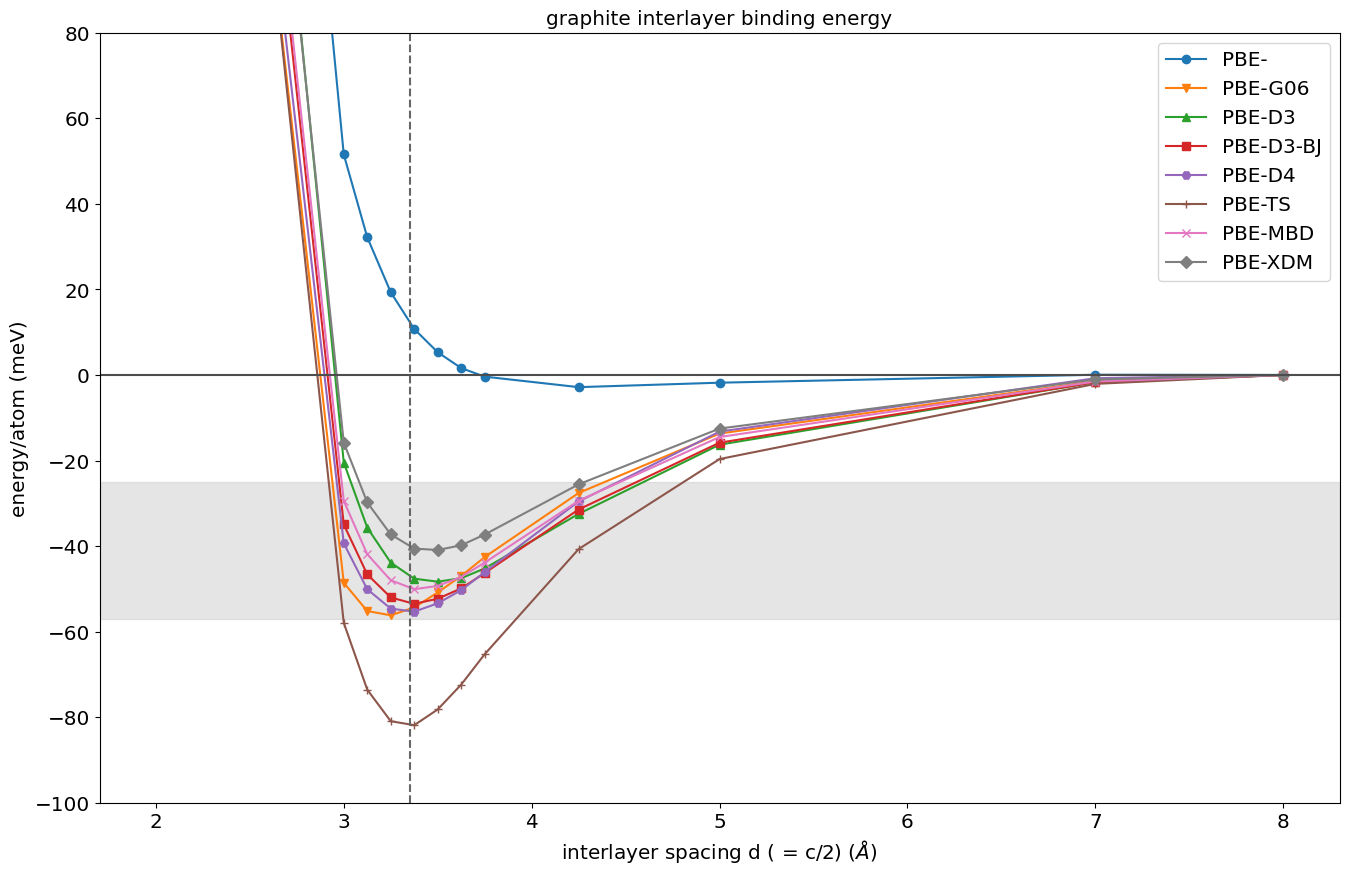

In [16]:
df  = pd.read_csv('./graphite_layer_separation.csv')
# scale by 1000 / 4 to get the energies per atom and in units of meV
dfdiff = (df.iloc[:,1:]) * 1000 / 4 # energy per atom in meV
# the c parmeter is 2x the interlayer spacing, d
dfdiff['c/2'] = df['crange'] / 2

styles = [f'{m}-' for m in ["o","v","^","s", "H","+","x","D"]]

# compared to this reference (and many others!) https://doi.org/10.1039/C3RA47187J
ax = dfdiff.plot(x='c/2', y=['PBE-','PBE-G06', 'PBE-D3', 'PBE-D3-BJ', 'PBE-D4', 'PBE-TS', 'PBE-MBD', 'PBE-XDM'],
                 ylabel='energy/atom (meV)',
                 ylim=(-100, 80), 
                 xlabel=r'interlayer spacing d ( = c/2) (${\AA}$)',
                 figsize = (16,10),
                 style=styles,
                 )
ax.axhline(0, color='0.3')
ax.axvline(3.355, ls='--', color='0.4') 
# Experimental binding energies reported shown in the figure are 31 ± 2, 43, 52 ± 5 and 35 (+15 to –10) meV per atom
ax.axhspan(ymin=-57, ymax=-25, color='0.8', alpha=0.5)
ax.set_title('graphite interlayer binding energy')
plt.savefig('graphite-interlayer-binding-castep-dispersions.pdf')
plt.savefig('graphite-interlayer-binding-castep-dispersions.png', dpi=300)
